In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100



In [4]:
duration_static, duration_bear = 2, 4

## Set time period

In [5]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read data

In [6]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

            Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...                   -1
2010-07-02        2678.58  ...                   -1
...                   ...  ...                  ...
2020-12-24       12137.42  ...                    1
2020-12-28       12203.97  ...                    1
2020-12-29       12155.89  ...                    1
2020-12-30       12189.07  ...                    1
2020-12-31       12248.16  ...                    1

[2643 rows x 248 columns]             Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...       

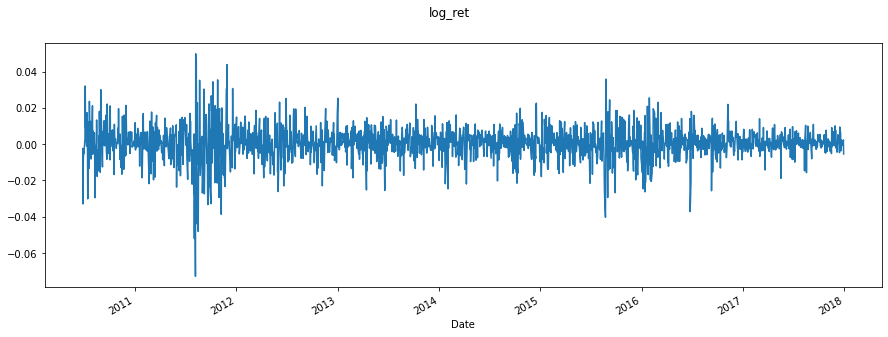

In [7]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

In [8]:
k=10
name = 'log_ret_MA'+str(k)
df[name] = df['log_ret'].rolling(k).mean()
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_1MTBill,Ret_3MTBill,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,hmm1 smoothed state,log_ret_MA10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-12,2821.58,1.093061e+09,0.160,0.150,0.198,0.297,1.000,1.809,3.021,4.008,2.92,2.43,0.52556,0.37,0.17,74.95,75.02,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,-0.11,-1.18,0.12,0.001,122.9010,0.0585,1078.75,3.426990e+09,1,1,0,1,0.001021,0.031250,0.013333,...,82.93,82.87,1166.21,4.963200e+09,2853.65,0.043,0.106,0.188,0.346,1.380,2.332,3.693,4.672,3.64,2.87,0.25063,77.33,77.35,1099.51,4.259230e+09,2971.76,0.038,0.066,0.145,0.328,1.469,2.454,3.717,4.610,3.67,2.80,0.24900,79.02,78.83,1150.23,4.724830e+09,-0.001020,0,-1,-0.000225
2010-07-13,2871.16,1.505901e+09,0.152,0.157,0.203,0.295,1.095,1.885,3.104,4.090,3.00,2.48,0.52594,0.38,0.17,77.15,77.23,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,1.76,1.61,0.63,0.001,124.6298,1.4035,1095.34,4.640460e+09,1,1,0,1,-0.017268,0.052632,-0.044586,...,82.20,82.21,1165.83,4.234510e+09,2872.46,0.068,0.096,0.183,0.343,1.431,2.401,3.762,4.727,3.69,2.89,0.25125,79.06,78.39,1106.75,3.878620e+09,2940.52,0.033,0.058,0.142,0.315,1.426,2.397,3.641,4.540,3.63,2.76,0.24888,77.62,78.35,1138.04,4.810560e+09,0.017419,-1,-1,0.001759
2010-07-14,2869.51,1.427629e+09,0.162,0.160,0.205,0.292,1.072,1.863,3.103,4.092,2.92,2.45,0.52563,0.38,0.17,77.04,76.77,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,-0.04,-0.15,-0.81,0.001,124.8590,3.2915,1095.17,4.521050e+09,1,1,0,1,0.000575,-0.061728,-0.018750,...,80.68,80.68,1159.90,5.212410e+09,2879.36,0.071,0.109,0.198,0.382,1.518,2.485,3.809,4.730,3.67,2.83,0.25194,79.81,80.09,1109.17,3.944280e+09,2887.24,0.015,0.056,0.137,0.320,1.450,2.410,3.643,4.519,3.56,2.75,0.24888,76.08,75.84,1116.48,6.874290e+09,-0.000575,-1,-1,0.004993
2010-07-15,2870.06,1.433918e+09,0.155,0.157,0.195,0.259,0.963,1.731,2.972,3.970,2.85,2.39,0.52469,0.37,0.19,76.62,76.88,0.0,-139.0,0.0,-0.1,0.0,9.5,0.0,3.0,0.02,-0.88,-0.13,0.001,124.8590,4.1023,1096.48,4.552470e+09,1,1,0,1,-0.000192,0.045161,0.019108,...,81.25,80.69,1165.81,4.261680e+09,2876.54,0.063,0.104,0.193,0.356,1.474,2.442,3.789,4.727,3.69,2.89,0.25219,80.16,79.19,1108.01,3.814440e+09,2824.79,0.015,0.056,0.134,0.290,1.391,2.357,3.613,4.525,3.56,2.78,0.24906,74.54,74.07,1091.76,6.208650e+09,0.000192,1,-1,0.005994
2010-07-16,2784.95,1.947350e+09,0.152,0.152,0.195,0.257,0.934,1.673,2.925,3.935,2.81,2.35,0.52125,0.37,0.19,76.01,75.78,0.0,-139.0,1.0,0.0,0.0,9.5,0.0,3.0,-2.94,-0.55,-0.93,0.001,122.2896,2.8977,1064.88,5.297350e+09,1,1,0,1,0.030561,0.019737,0.032895,...,81.91,81.64,1174.17,4.411640e+09,2840.66,0.058,0.109,0.203,0.341,1.423,2.375,3.734,4.682,3.57,2.82,0.25194,78.86,79.13,1094.60,4.521050e+09,2836.95,0.020,0.056,0.147,0.297,1.380,2.353,3.617,4.537,3.60,

## Three regimes, common variance

In [9]:
hmm0 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=3,trend='c')
hmm0_results = hmm0.fit(search_reps = 100)
print(hmm0_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                8927.934
Date:                Wed, 09 Feb 2022   AIC                         -17835.869
Time:                        19:27:43   BIC                         -17780.479
Sample:                             0   HQIC                        -17815.467
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.000    -12.620      0.000      -0.002      -0.002
                             Regime 1 parameters    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


Note that the transition prob. from bear to static and from bull to static are too high.

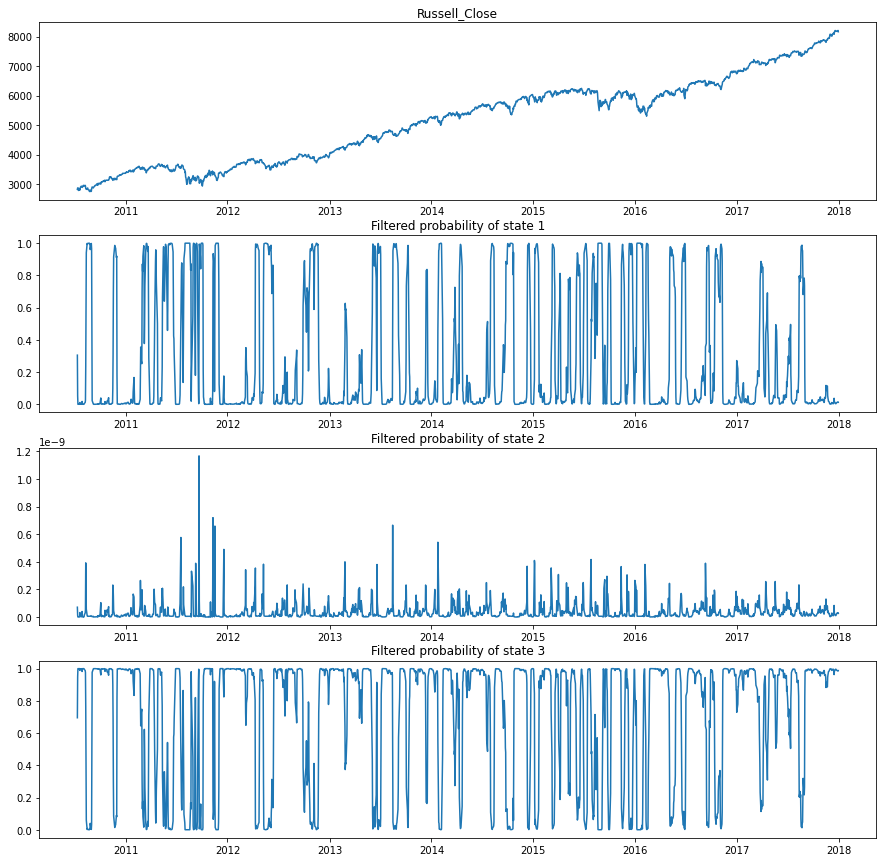

In [10]:
fig, axes = plt.subplots(4, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of state 1')
 
ax = axes[2]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of state 2')

ax = axes[3]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[2])
ax.set(title='Filtered probability of state 3')

plt.show()


## Two regimes, switching mean and variance

In [11]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                8985.724
Date:                Wed, 09 Feb 2022   AIC                         -17959.448
Time:                        19:27:48   BIC                         -17926.214
Sample:                             0   HQIC                        -17947.207
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.000     -7.625      0.000      -0.002      -0.001
sigma2      5.498e-06   4.43e-06      1.241      0.2

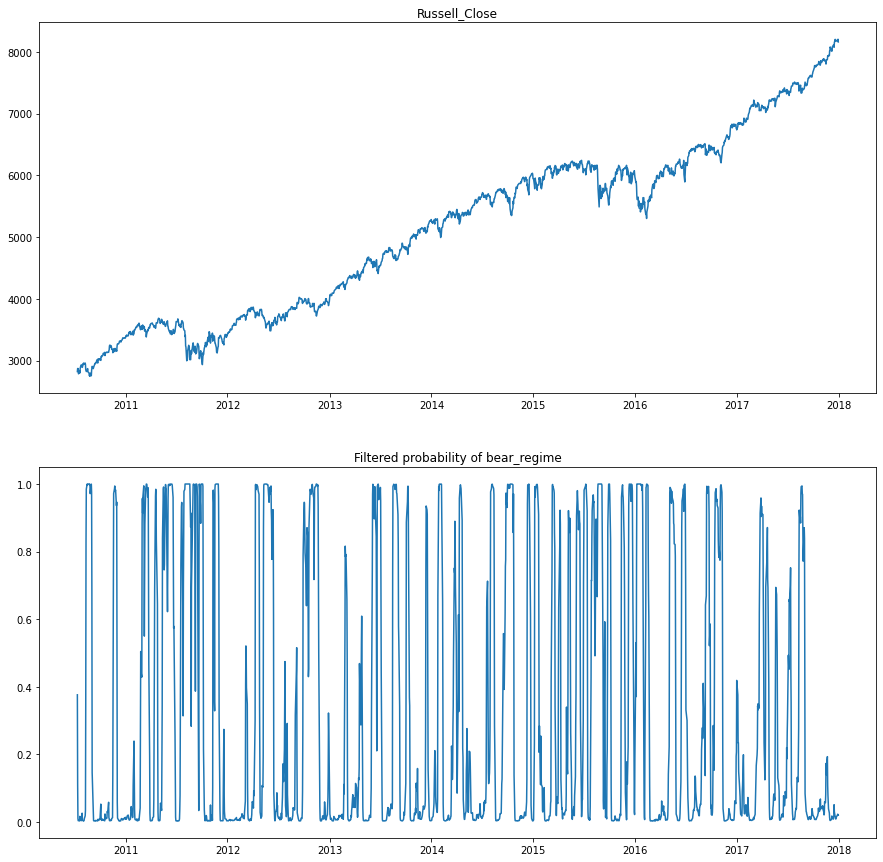

In [12]:
plotProb_train(hmm1_results)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


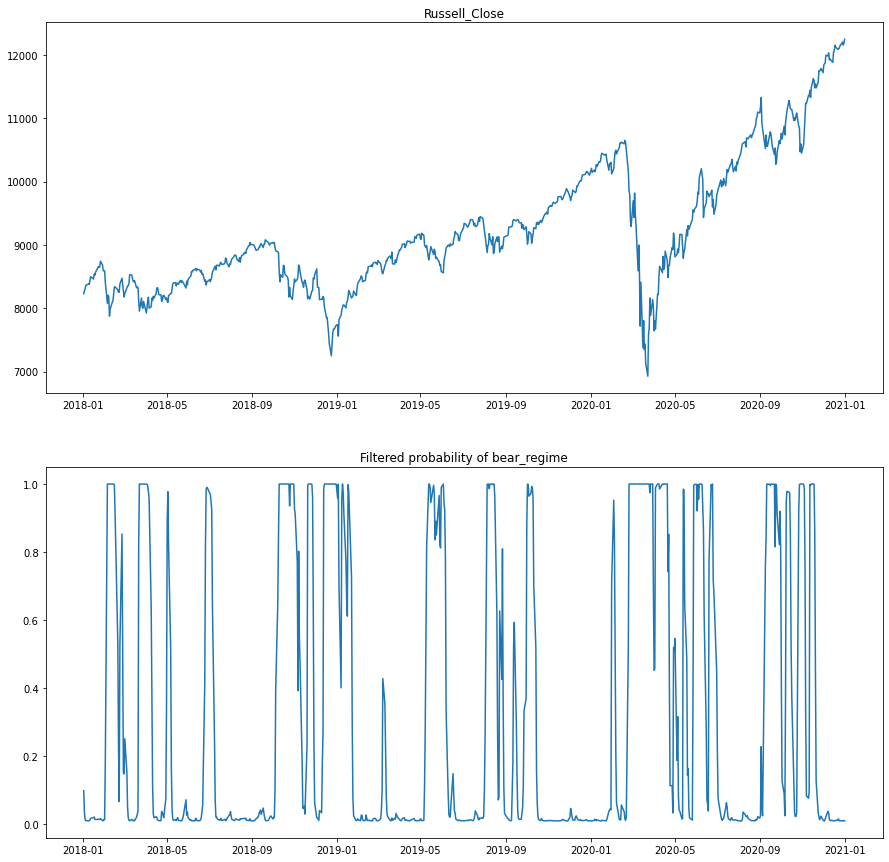

In [13]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)
plotProb_test(hmm1_test_results)

In [14]:
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.98 0.15


In [15]:
label_filtered = labeling(hmm1_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    15.956522
dtype: float64
0    4.258065
dtype: float64
0    4.5
dtype: float64
248
1.02974414528519 2.0490072521895546


In [16]:
np.histogram(label_filtered)

(array([ 252,    0,    0,    0,    0,  528,    0,    0,    0, 1100]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

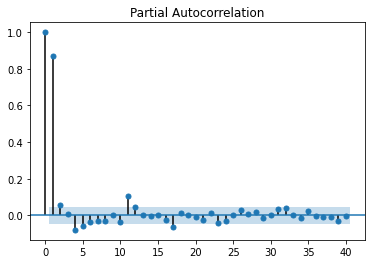

In [17]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

In [18]:
sm.tsa.pacf(label_filtered)

array([ 1.00000000e+00,  8.72818400e-01,  5.48593220e-02,  4.59538050e-03,
       -8.00350985e-02, -5.64787524e-02, -3.45797405e-02, -3.31243944e-02,
       -2.88383123e-02,  1.75148521e-03, -3.41760271e-02,  1.04372320e-01,
        4.44566745e-02, -2.21289501e-04, -3.76224363e-03,  2.59716477e-03,
       -2.34084886e-02, -6.20456953e-02,  1.37785975e-02,  2.49585142e-03,
       -7.55403937e-03, -2.78654425e-02,  1.23634736e-02, -4.01519429e-02,
       -2.97041513e-02,  2.66800587e-03,  2.69074886e-02,  7.99235199e-03,
        2.02689264e-02, -1.38249717e-02, -2.92526425e-04,  3.66161843e-02,
        3.93071972e-02,  6.05133406e-04, -1.24859084e-02,  2.37823210e-02,
       -3.75758946e-03, -7.56288225e-03, -9.70760991e-03, -3.10919544e-02,
       -3.27919243e-03])

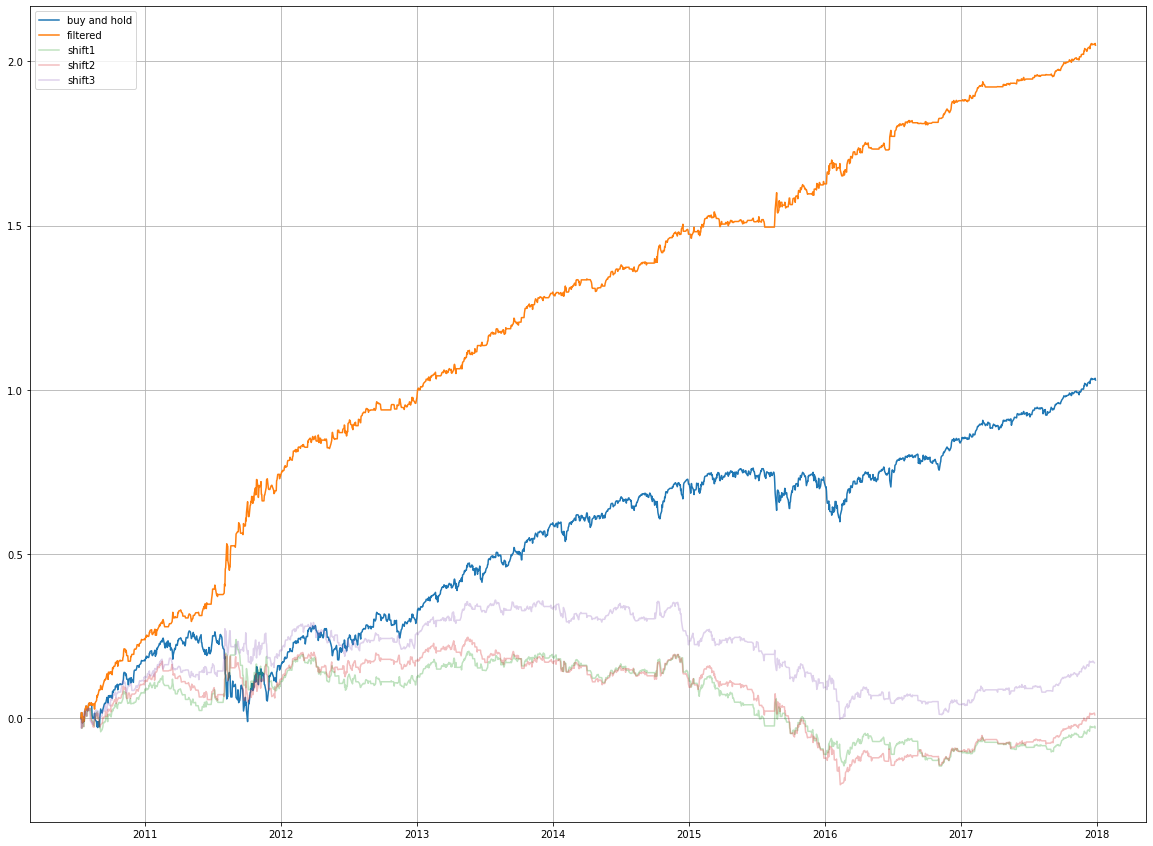

In [19]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [20]:
label_filtered = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    16.464286
dtype: float64
0    2.886792
dtype: float64
0    5.035714
dtype: float64
108
0.4205309960530377 0.9393650660947883


In [21]:
np.histogram(label_filtered)

(array([141,   0,   0,   0,   0, 153,   0,   0,   0, 460]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

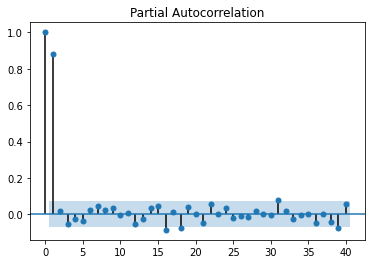

array([ 1.00000000e+00,  8.78142953e-01,  1.83070585e-02, -5.34337014e-02,
       -2.48008033e-02, -3.74918402e-02,  2.58872418e-02,  4.46611708e-02,
        2.70193400e-02,  3.41357864e-02, -3.41254155e-03,  5.94406050e-03,
       -5.08975567e-02, -2.69457842e-02,  3.63856548e-02,  4.60415699e-02,
       -8.47250782e-02,  1.49114433e-02, -7.35953475e-02,  4.24819943e-02,
        5.92342716e-04, -4.90825406e-02,  5.60580069e-02,  1.26056767e-03,
        3.32015585e-02, -2.20255394e-02, -9.62253290e-03, -1.19965107e-02,
        2.12158560e-02,  4.75750164e-03, -2.36642983e-03,  7.74071978e-02,
        1.77816195e-02, -2.65026430e-02, -5.44846534e-03,  4.03240887e-03,
       -4.66586312e-02,  2.23150077e-03, -4.03621767e-02, -7.20074941e-02,
        5.85618476e-02])

In [22]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

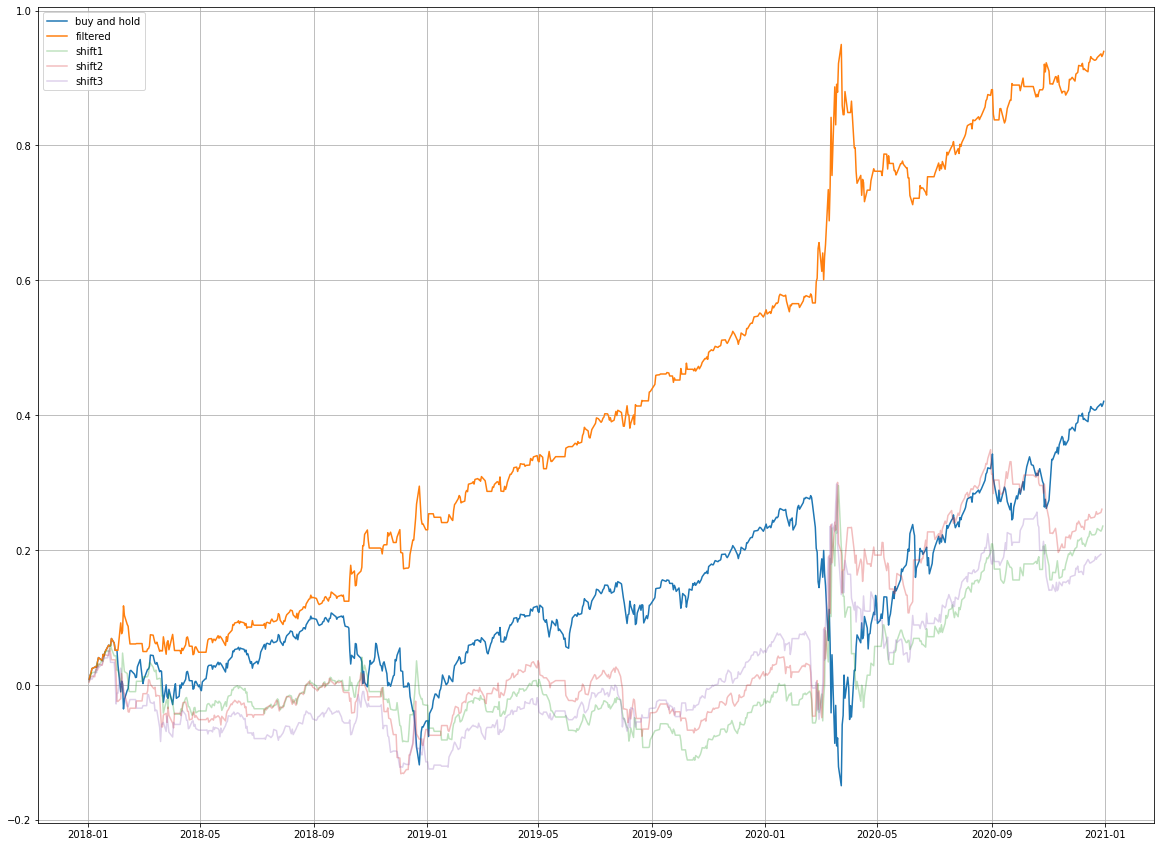

In [23]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob.

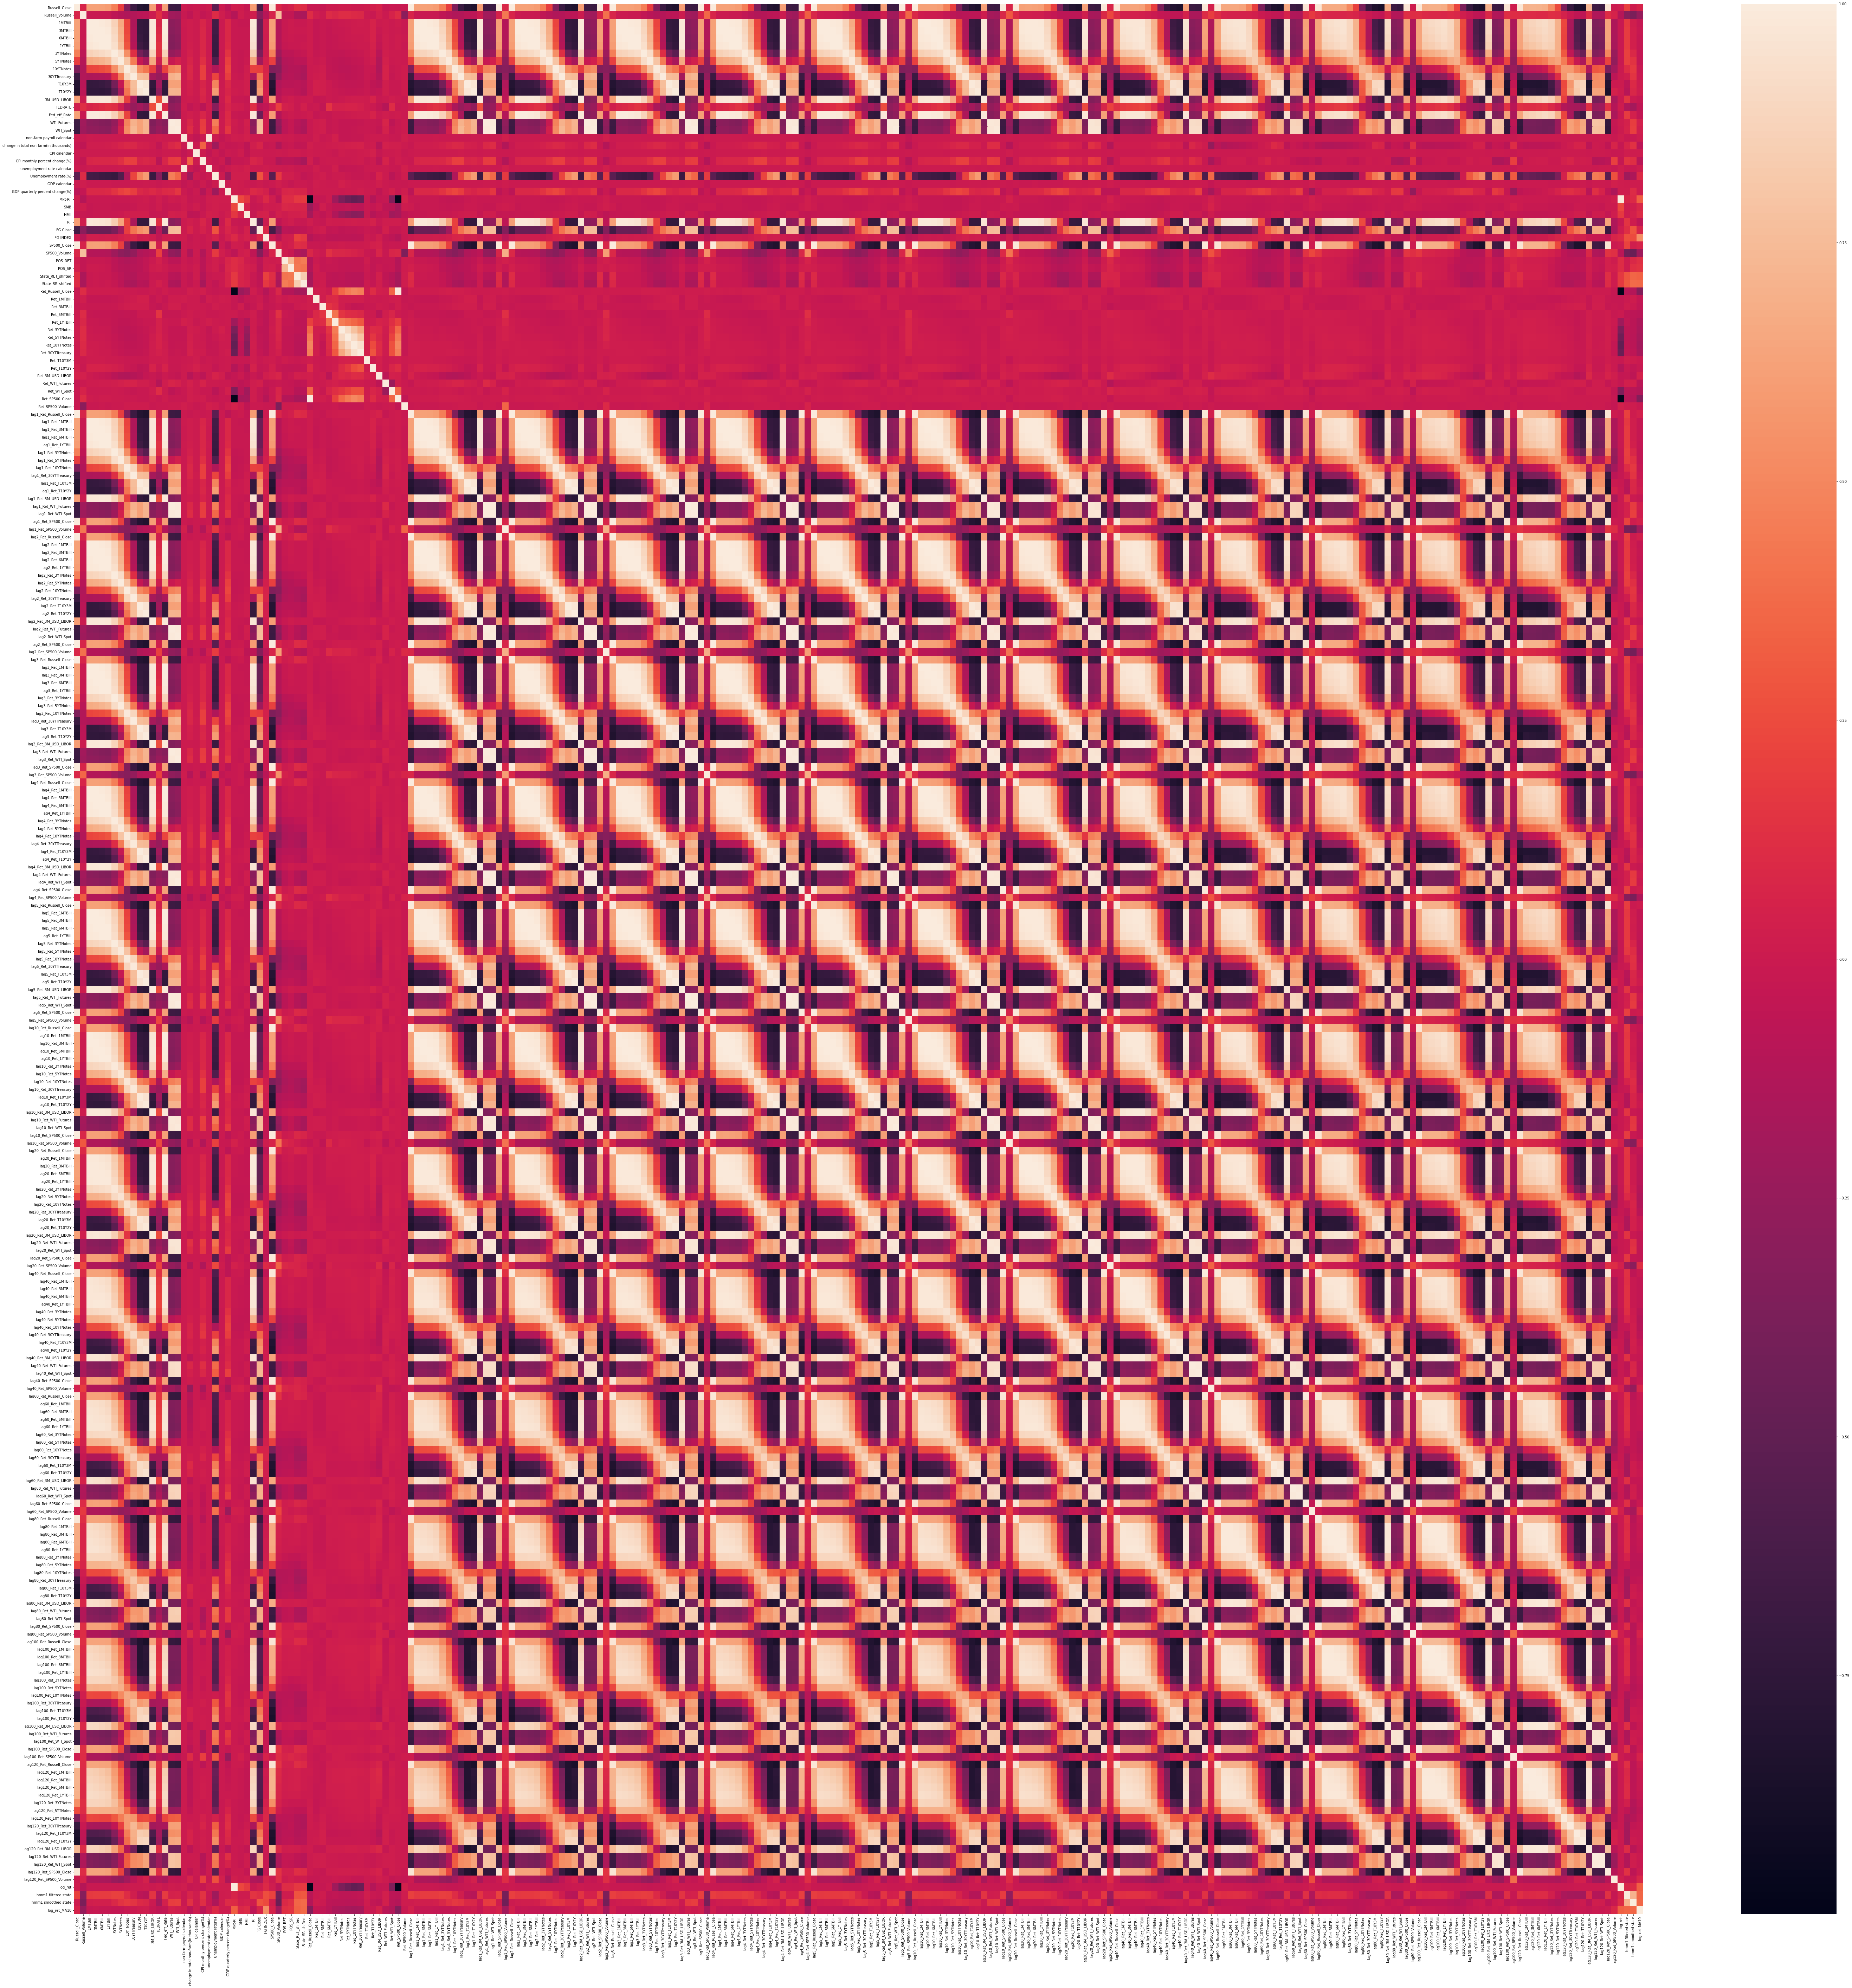

In [24]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(100,100)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [25]:
for i,j in zip (df[df.columns.to_list()].apply(lambda x: x.autocorr()) , df.columns):
  print(j,i)

Russell_Close 0.9994100346736631
Russell_Volume 0.3476325644319024
1MTBill 0.9994742713192872
3MTBill 0.9997380924464452
6MTBill 0.9997754750906171
1YTBill 0.9997113858979236
3YTNotes 0.9987002898587065
5YTNotes 0.9975647327389109
10YTNotes 0.9970776249533378
30YTTreasury 0.9975047745881185
T10Y3M 0.9984570048627632
T10Y2Y 0.9989848542849058
3M_USD_LIBOR 0.9998675947725058
TEDRATE 0.989528492457641
Fed_eff_Rate 0.999181606135706
WTI_Futures 0.9965250590637126
WTI_Spot 0.9985454520061113
non-farm payroll calendar -0.04984051036682596
change in total non-farm(in thousands) 0.9488850374972435
CPI calendar -0.049840510366825956
CPI monthly percent change(%) 0.970677915275989
unemployment rate calendar -0.04984051036682596
Unemployment rate(%) 0.9953693426578969
GDP calendar -0.008359954417231773
GDP quarterly percent change(%) 0.9790800555385086
Mkt-RF -0.15068202426071334
SMB -0.05506388660935379
HML 0.054676000766199516
RF 0.9983402142813249
FG Close 0.9964983181825954
FG INDEX 0.9584917

In [26]:
# dependent variables used for transition prob.
# hmm1 smoothed state is not measurable; others contain nan

df_train_tvtp = df_train.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_train_tvtp = df_train_tvtp.dropna()

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()

df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA10,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-12,-1.645897,-0.006259,-0.079262,-0.207987,-0.266970,-0.214635,0.324868,0.930762,1.547297,1.444311,1.442961,1.310244,0.069513,0.769954,-0.338953,-0.007443,-0.003852,-0.22286,-3.464383,-0.224171,-1.184641,-0.22286,1.586246,-0.183077,0.819976,-0.183489,-2.286082,0.264463,0.315463,-1.888717,0.037338,-1.690642,-0.308528,0.165135,-0.023542,-0.407304,-0.318183,0.279700,0.388079,0.364400,...,0.285376,0.283379,-1.383967,1.443359,-1.510320,-0.463379,-0.250923,-0.180746,0.093934,1.440340,1.990103,2.431404,2.247222,2.360436,1.910437,-0.714378,0.036385,0.037736,-1.520480,0.591761,-1.397230,-0.488844,-0.421574,-0.334225,0.067700,1.698436,2.206350,2.381077,2.076540,2.338619,1.745959,-0.716277,0.096106,0.088475,-1.368199,1.106613,-0.170059,-0.603458,-0.306883,1
2010-07-13,-1.610775,1.212283,-0.107588,-0.185912,-0.252559,-0.219962,0.566550,1.108676,1.721073,1.589444,1.579360,1.396138,0.070601,0.862577,-0.338953,0.083665,0.087676,-0.22286,-3.464383,-0.224171,-1.184641,-0.22286,1.586246,-0.183077,0.819976,1.846317,3.123389,1.356764,0.315463,-1.806267,0.282387,-1.651198,1.332441,-1.814305,-0.103409,-0.264350,0.110303,-1.837335,-1.140107,-1.194325,...,0.254645,0.255588,-1.384903,0.580951,-1.496357,-0.335201,-0.295394,-0.200621,0.083092,1.580069,2.141588,2.555745,2.335732,2.441802,1.945087,-0.712127,0.109826,0.081896,-1.502559,0.141543,-1.420607,-0.517497,-0.460938,-0.347067,0.017768,1.579898,2.083407,2.247898,1.966111,2.274330,1.677008,-0.716737,0.036233,0.067942,-1.398580,1.206721,1.829900,-1.824665,0.465935,1
2010-07-14,-1.611944,0.981255,-0.072181,-0.176452,-0.246795,-0.227951,0.508037,1.057175,1.718979,1.592984,1.442961,1.344602,0.069714,0.862577,-0.338953,0.079109,0.068625,-0.22286,-3.464383,-0.224171,-1.184641,-0.22286,1.586246,-0.183077,0.819976,-0.107506,-0.289037,-1.727381,0.315463,-1.795336,0.626366,-1.651602,1.170963,0.116897,-0.067783,-0.129543,0.173707,0.436342,0.316444,-0.000922,...,0.190657,0.191164,-1.399507,1.738300,-1.491235,-0.319819,-0.237581,-0.140995,0.224033,1.818430,2.326004,2.640441,2.340560,2.409256,1.841138,-0.709622,0.141664,0.154080,-1.496569,0.219211,-1.460476,-0.620648,-0.470779,-0.368469,0.036973,1.646059,2.111447,2.251403,1.932983,2.161825,1.659770,-0.716737,-0.029627,-0.039429,-1.452314,3.616586,-0.121757,-1.824665,1.725908,1
2010-07-15,-1.611555,0.999817,-0.096966,-0.185912,-0.275617,-0.315839,0.230740,0.748165,1.444706,1.377055,1.323612,1.241529,0.067023,0.769954,-0.275121,0.061716,0.073181,-0.22286,-3.464383,-0.224171,-1.184641,-0.22286,1.586246,-0.183077,0.819976,-0.042379,-1.704419,-0.270979,0.315463,-1.79

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_train

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-7.958160,12.597105,0.233173,8.907336,0.416456
1,-8.033364,12.515988,0.467094,9.410148,-4.935564
2,-8.083443,12.765685,0.395396,9.912414,-0.573412
3,-7.932379,12.817447,0.382732,9.002669,1.437361
4,-8.037034,12.407561,0.226780,9.830952,4.226643
...,...,...,...,...,...
1875,31.556686,9.176782,8.028451,-3.265450,1.387226
1876,31.560736,9.230941,8.132418,-3.639965,1.047759
1877,31.652538,9.419825,7.984080,-3.973158,2.647604
1878,31.787495,9.229579,8.255429,-4.159490,0.785707


In [28]:
pca.explained_variance_ratio_.sum()

0.8105513827174431

In [29]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,
                                    switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                8851.098
Date:                Wed, 09 Feb 2022   AIC                         -17674.197
Time:                        19:28:45   BIC                         -17596.650
Sample:                             0   HQIC                        -17645.634
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007   5.47e-05     12.212      0.000       0.001       0.001
sigma2       1.52e-06   8.59e-08     17.681      0.0

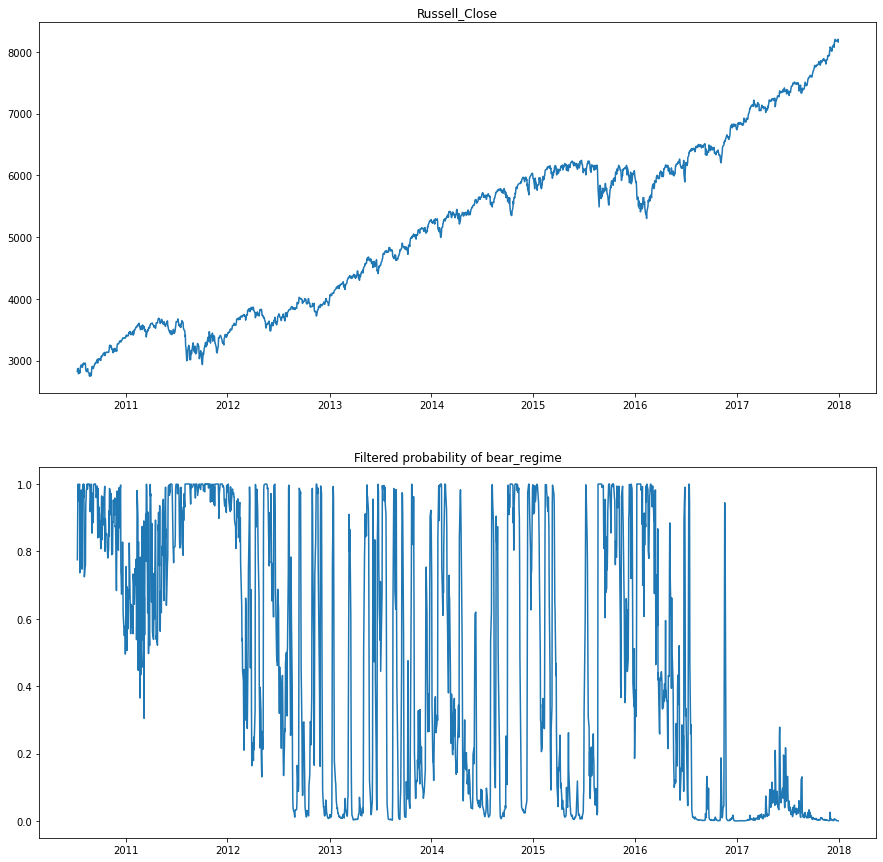

In [30]:
plotProb_train(hmm2_results)

In [31]:
pd.options.mode.use_inf_as_na = True
df_test.columns[df_test.isna().any()].tolist()

['Ret_T10Y3M', 'Ret_T10Y2Y']

In [32]:
df_test_tvtp = df_test.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y','POS_RET','POS_SR','State_RET_shifted','State_SR_shifted'])
df_test_tvtp = df_test_tvtp.dropna()

df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1

df_test_tvtp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,Ret_1YTBill,Ret_3YTNotes,Ret_5YTNotes,Ret_10YTNotes,...,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,log_ret_MA10,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2.184427,-0.274523,3.790792,3.771732,3.673027,3.790892,2.907044,1.965477,0.379020,-0.667197,-1.796510,-1.936560,3.422366,-0.063654,3.650525,-0.611242,-0.609344,-0.22286,0.100394,-0.224171,0.751148,-0.22286,-1.484434,-0.183077,1.077331,0.858551,0.680402,-0.485156,3.738671,-0.723458,0.225324,2.154004,-0.389314,-0.838149,-0.059507,-0.243810,-0.586982,-0.421122,-0.547293,-0.964075,...,-1.139188,-1.141100,1.814950,-0.461220,1.919666,4.463805,3.933796,3.631357,3.234392,1.777333,0.835305,-0.168944,-0.726728,-1.642814,-1.485224,3.128634,-1.142488,-1.136740,1.881769,-0.533365,1.916427,4.640068,4.366068,3.856439,3.393927,1.885892,0.955355,-0.065201,-0.646310,-1.502627,-1.391302,3.321961,-1.337848,-1.340706,1.854378,-0.707106,0.839016,0.617749,0.145995,1
2018-01-03,2.218500,-0.288002,3.900556,3.746504,3.756612,3.825514,2.907044,1.946749,0.351803,-0.716754,-1.779460,-2.005275,3.419504,0.214216,3.650525,-0.559062,-0.550949,-0.22286,0.100394,-0.224171,0.751148,-0.22286,-1.484434,-0.183077,1.077331,0.576332,-0.734979,-0.378068,3.738671,-0.530311,0.688840,2.195017,-0.157518,-0.574310,-0.034071,-0.206009,-0.142748,-0.014455,0.086137,0.218860,...,-1.206965,-1.206366,1.805911,-0.522099,1.839007,4.494568,3.920455,3.663158,3.252461,1.725277,0.762856,-0.262651,-0.805582,-1.691635,-1.554523,3.128416,-1.183665,-1.186420,1.793130,-0.163110,1.926349,4.685913,4.331625,3.890684,3.455382,1.954810,0.994179,-0.019640,-0.594251,-1.470483,-1.391302,3.320889,-1.312616,-1.312473,1.865792,-0.828491,0.572743,0.617749,0.128948,1
2018-01-04,2.240828,-0.042547,3.829741,3.762272,3.765258,3.854810,2.970645,2.014637,0.358084,-0.714984,-1.745360,-2.005275,3.442059,0.214216,3.650525,-0.543325,-0.546393,-0.22286,0.100394,-0.224171,0.751148,-0.22286,-1.484434,-0.183077,1.077331,0.391804,-0.521703,0.500057,3.738671,-0.384082,1.273969,2.221003,0.054252,-0.355941,-0.046821,-0.058149,-0.122080,-0.271944,-0.370180,-0.069067,...,-1.182127,-1.184049,1.871619,-0.534798,1.847677,4.402279,3.898219,3.611482,3.198253,1.629385,0.701384,-0.273463,-0.786271,-1.675361,-1.519874,3.149799,-1.173902,-1.174531,1.800828,-0.708586,1.950796,4.599954,4.331625,3.869281,3.436177,1.932756,0.944571,-0.040668,-0.589518,-1.486555,-1.391302,3.320889,-1.292943,-1.288518,1.894304,-1.215042,0.352852,0.617749,0.418664,1
2018-01-05,2.278663,-0.412982,3.819118,3.746504,3.742201,3.809535,3.026613,2.045070,0.408332,-0.679586,-1.694211,-1.988096,3.442402,0.399462,3.650525,-0.566930,-0.561717,4.48474,-0.080505,-0.224171,0.751148,4.48474,-1.484434,-0.183077,1.077331,0.652314,-0.676813,-0.527991,3.738671,-0.34

In [33]:
principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_test

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,32.053257,9.167343,8.515646,-3.901928,-0.407824
1,32.261637,9.228198,8.655076,-4.056792,0.844175
2,32.394394,9.376349,8.644704,-4.084016,0.928872
3,32.495814,9.571728,8.663175,-3.944148,0.598284
4,32.639703,9.819940,8.749222,-3.722640,1.112598
...,...,...,...,...,...
749,12.772540,-20.491712,-10.473364,-8.068577,1.109482
750,12.996048,-20.566158,-10.768424,-8.364117,0.416468
751,13.052451,-20.625582,-10.953814,-8.307449,1.099306
752,12.826584,-20.211086,-10.579820,-9.105651,1.857946


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


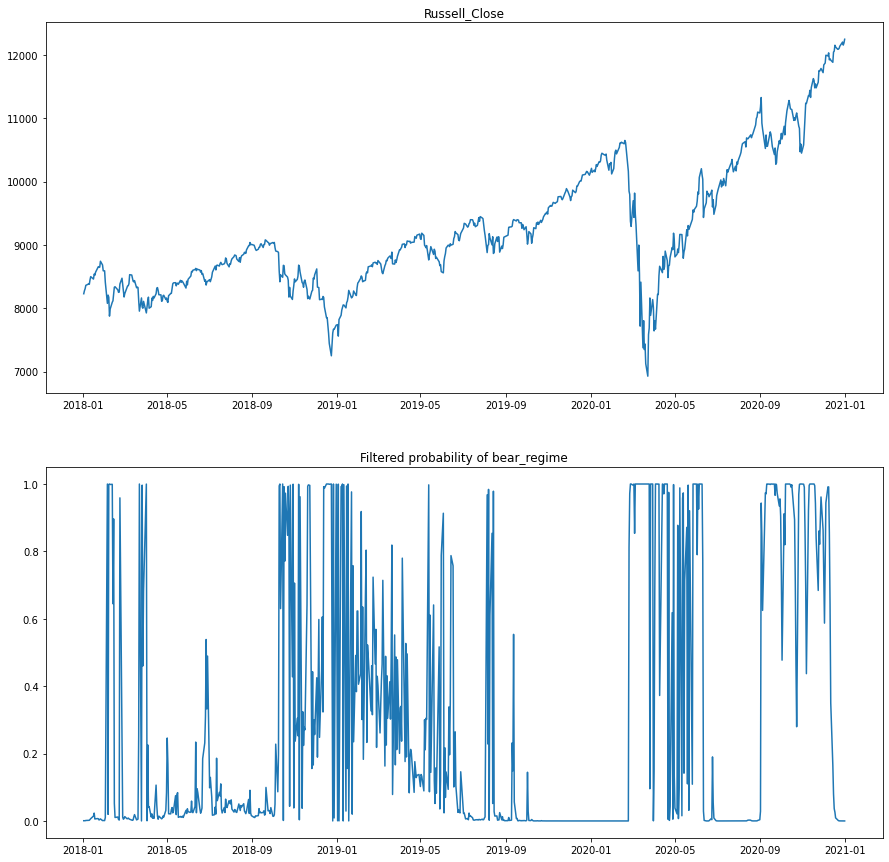

In [34]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,
                                    switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)
plotProb_test(hmm2_test_results)

In [35]:
t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
print(t1,t2)

0.95 0.77


In [36]:
label_filtered = labeling(hmm2_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    15.987013
dtype: float64
0    2.007463
dtype: float64
0    4.010526
dtype: float64
305
1.02974414528519 0.5102682378665968


In [37]:
np.histogram(label_filtered)

(array([ 381,    0,    0,    0,    0,  269,    0,    0,    0, 1230]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

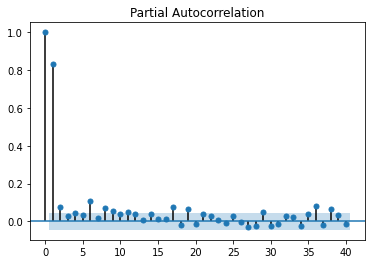

array([ 1.        ,  0.83120691,  0.0760902 ,  0.02900538,  0.04442973,
        0.03546422,  0.10603979,  0.01820935,  0.07246048,  0.05730893,
        0.03648086,  0.05124037,  0.03815041,  0.00844488,  0.04071485,
        0.01496679,  0.01139754,  0.07486832, -0.01676832,  0.063873  ,
       -0.01463448,  0.0415175 ,  0.02660438,  0.00932453, -0.00694561,
        0.02620071, -0.00142431, -0.02945126, -0.02638261,  0.04900842,
       -0.02561209, -0.01459   ,  0.02998154,  0.02099649, -0.02620567,
        0.03896064,  0.08251422, -0.02065455,  0.06449834,  0.03577217,
       -0.01370018])

In [38]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

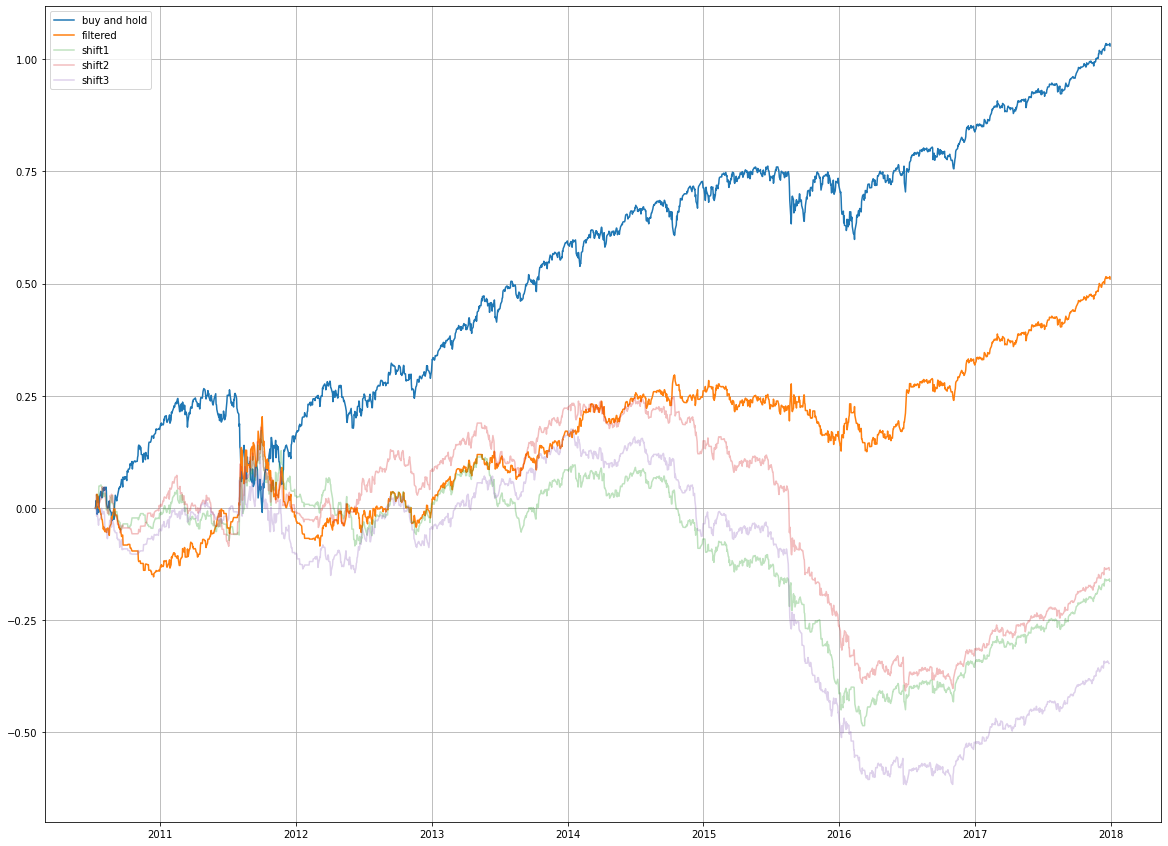

In [39]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [40]:
label_filtered = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    10.5
dtype: float64
0    1.193548
dtype: float64
0    2.653061
dtype: float64
135
0.4205309960530377 1.2691445958487688


In [41]:
np.histogram(label_filtered)

(array([130,   0,   0,   0,   0,  37,   0,   0,   0, 587]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

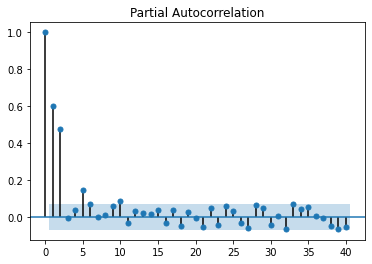

array([ 1.        ,  0.59817891,  0.47433076, -0.00500331,  0.03599912,
        0.14347864,  0.06863734, -0.00402468,  0.0101321 ,  0.05709904,
        0.08743851, -0.03571165,  0.03081721,  0.02110283,  0.01733584,
        0.03494843, -0.03534827,  0.03405409, -0.04803209,  0.02521265,
       -0.00523607, -0.05702224,  0.04681477, -0.04562193,  0.05690411,
        0.03165715, -0.03402019, -0.0600125 ,  0.06391497,  0.05006044,
       -0.04686435,  0.00493539, -0.06721075,  0.06695256,  0.04424102,
        0.05165544,  0.00675083, -0.00469745, -0.04920724, -0.06395754,
       -0.05292908])

In [42]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

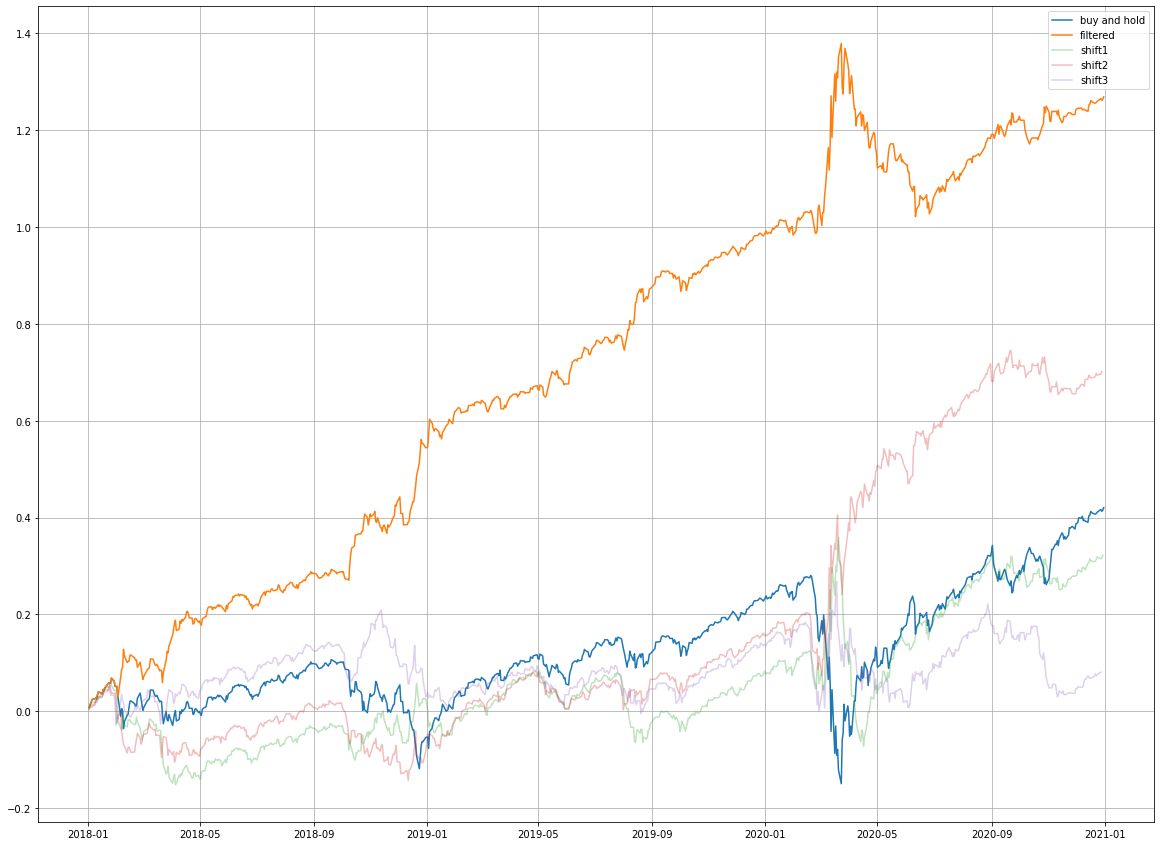

In [43]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob. and mean.

In [44]:
# switching mean dependent variabels
df_train_exog = df_train[['SMB','HML']]
df_test_exog = df_test[['SMB','HML']]

In [45]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                               exog_tvtp = principalDf_train, switching_exog = True, switching_variance=True)
hmm3_results = hmm3.fit(search_reps = 100)
print(hmm3_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                8870.986
Date:                Wed, 09 Feb 2022   AIC                         -17705.973
Time:                        19:29:21   BIC                         -17606.270
Sample:                             0   HQIC                        -17669.249
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.409      0.001       0.000       0.001
x1             0.0008      0.000      3.607      0.0

In [46]:
t1,t2 = Search_train(hmm3_results, duration_static, duration_bear)
print(t1,t2)

1.0 0.99


In [47]:
label_filtered = labeling(hmm3_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    19.535714
dtype: float64
0    2.729412
dtype: float64
0    4.0
dtype: float64
170
1.02974414528519 1.3410893254366745


In [48]:
np.histogram(label_filtered)

(array([   8,    0,    0,    0,    0,  232,    0,    0,    0, 1640]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

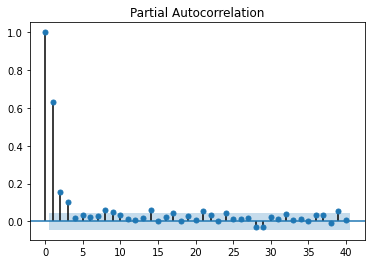

array([ 1.00000000e+00,  6.32749555e-01,  1.56988074e-01,  1.00084598e-01,
        1.99093889e-02,  3.35052304e-02,  2.19647229e-02,  2.89319124e-02,
        5.84276787e-02,  4.88894293e-02,  3.53935072e-02,  1.44595798e-02,
        5.27049836e-03,  1.83171422e-02,  6.23646135e-02, -3.52073621e-04,
        2.25470525e-02,  4.47881114e-02,  2.39317565e-03,  3.02217859e-02,
        5.94300288e-03,  5.70551742e-02,  3.44631639e-02,  6.69368317e-05,
        4.31304724e-02,  1.20745118e-02,  1.05897929e-02,  2.01399474e-02,
       -3.18174848e-02, -3.04529567e-02,  2.38764394e-02,  1.26012254e-02,
        3.83043726e-02,  7.51306172e-03,  1.20614494e-02,  3.70271737e-03,
        3.11417848e-02,  3.53667720e-02, -1.06277144e-02,  5.58628835e-02,
        4.95406838e-03])

In [49]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [50]:
hmm3_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                               exog_tvtp = principalDf_test, switching_exog = True,switching_variance=True)
hmm3_test_results = hmm3_test.fit(start_params = hmm3_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [51]:
label_filtered = labeling(hmm3_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    17.675676
dtype: float64
0    2.275
dtype: float64
0    2.5
dtype: float64
80
0.4205309960530377 1.0334591496302976


In [52]:
np.histogram(label_filtered)

(array([ 10,   0,   0,   0,   0,  91,   0,   0,   0, 653]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

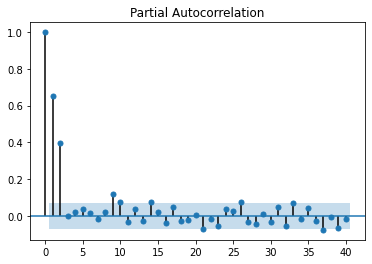

array([ 1.        ,  0.65181539,  0.39578303, -0.00388329,  0.02094047,
        0.03641295,  0.01315031, -0.01641229,  0.01957323,  0.11927455,
        0.07664295, -0.03416533,  0.03720025, -0.02967097,  0.07662098,
        0.01791017, -0.0378868 ,  0.04525886, -0.0288195 , -0.02365307,
        0.00276632, -0.06969747, -0.01674508, -0.05342628,  0.03826095,
        0.02594573,  0.07402152, -0.03391536, -0.04525065,  0.01138473,
       -0.03544422,  0.04976662, -0.05769232,  0.07135708, -0.01851708,
        0.04235551, -0.03022538, -0.07727583, -0.00774173, -0.06416164,
       -0.01594841])

In [53]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Two regimes, switching mean and variance with other dependent variables in mean.

In [54]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = df_train_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_results = hmm4.fit(search_reps = 100)
print(hmm4_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                9005.476
Date:                Wed, 09 Feb 2022   AIC                         -17990.952
Time:                        19:29:47   BIC                         -17935.561
Sample:                             0   HQIC                        -17970.550
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.000    -12.317      0.000      -0.002      -0.002
x1             0.0005      0.000      2.681      0.0

In [55]:
t1,t2 = Search_train(hmm4_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.87


In [56]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    25.362069
dtype: float64
0    2.228261
dtype: float64
0    4.1
dtype: float64
199
1.02974414528519 1.9164019858017776


In [57]:
np.histogram(label_filtered)

(array([ 205,    0,    0,    0,    0,  205,    0,    0,    0, 1470]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

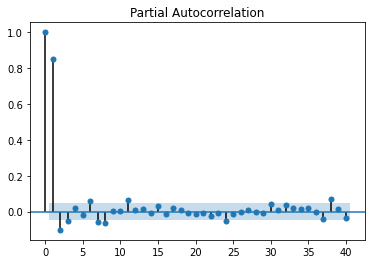

array([ 1.00000000e+00,  8.52232183e-01, -1.02551845e-01, -5.04861189e-02,
        1.82242589e-02, -1.71039295e-02,  5.85722030e-02, -5.96127247e-02,
       -6.11981169e-02,  7.72415817e-04,  2.34104332e-03,  6.33214444e-02,
        8.44488951e-03,  1.31322577e-02, -5.82054485e-03,  3.12251248e-02,
       -1.16784874e-02,  1.71477540e-02,  7.75278799e-03, -5.70685891e-03,
       -1.55756546e-02, -7.40856898e-03, -2.48600665e-02, -1.04514876e-02,
       -5.01885845e-02, -1.19779291e-02, -1.58595853e-03,  1.07018440e-02,
       -4.47394149e-03, -8.04936130e-03,  4.00809209e-02,  9.30507669e-03,
        3.39284079e-02,  1.99553037e-02,  1.59327535e-02,  1.83732858e-02,
       -2.07659743e-03, -4.00169481e-02,  6.81379865e-02,  1.30131145e-02,
       -3.82874484e-02])

In [58]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [59]:
hmm4_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = df_test_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_test_results = hmm4_test.fit(start_params = hmm4_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    19.758621
dtype: float64
0    1.485714
dtype: float64
0    4.642857
dtype: float64
91
0.4205309960530377 1.083213545451129


In [61]:
np.histogram(label_filtered)

(array([130,   0,   0,   0,   0,  52,   0,   0,   0, 572]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

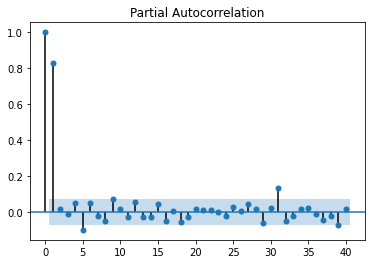

array([ 1.        ,  0.82685453,  0.0182796 , -0.00842117,  0.05036333,
       -0.09891409,  0.05330015, -0.02148642, -0.04777798,  0.07458971,
        0.01740333, -0.02737081,  0.05685356, -0.02644763, -0.02962824,
        0.04487841, -0.05177364,  0.00873053, -0.05705284, -0.02562836,
        0.01515434,  0.01232777,  0.00969172,  0.00345285, -0.02393065,
        0.02572969,  0.0039586 ,  0.04686249,  0.01942272, -0.05771177,
        0.02490556,  0.1315799 , -0.04923959, -0.02368424,  0.01595577,
        0.02201454, -0.00916434, -0.04387693, -0.02004682, -0.07111622,
        0.01699349])

In [62]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [63]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog = principalDf_train, 
                                switching_exog = True,switching_variance=True)
hmm5_results = hmm5.fit(search_reps = 100)
print(hmm5_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 1880
Model:               MarkovRegression   Log Likelihood                     nan
Date:                Wed, 09 Feb 2022   AIC                                nan
Time:                        19:30:15   BIC                                nan
Sample:                             0   HQIC                               nan
                               - 1880                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.1602        nan        nan        nan         nan         nan
x1          -594.7166        nan        nan        n

This model labels the observables from a perspective fairly different from bear and bull concept.

In [64]:
t1,t2 = Search_train(hmm5_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.0 0.0


In [65]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    1.0
dtype: float64
Series([], dtype: float64)
0    1880.0
dtype: float64
1
1.02974414528519 -1.02974414528519


In [66]:
np.histogram(label_filtered)

(array([   0,    0,    0,    0,    0, 1880,    0,    0,    0,    0]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]))

LinAlgError: ignored

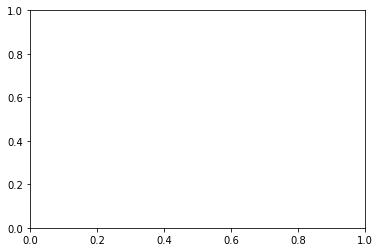

In [67]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

In [ ]:
hmm5_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c', exog = principalDf_test, 
                                switching_exog = True, switching_variance=True)
hmm5_test_results = hmm5_test.fit(start_params = hmm5_results.params, maxiter = 0)

In [ ]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print((duration(label_filtered))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()
sm.tsa.pacf(label_filtered)

## Method 1
## Pick thresholds such that the durations meet certain criteria

In [ ]:
## some tech issue for this function

#from scipy.optimize import minimize
def FindTresholds(model_train):
  threshold1,threshold2 = 70,30
  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  duration_bear = duration(label)
  duration_bear_mean = duration_bear.mean()
    
  #find threshold1 such that the bear duration reach 4
  while(duration_bear_mean <=4 and threshold1 <=99):
    threshold1+=1
    label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
    duration_bear = duration(label)
    duration_bear_mean = duration_bear.mean()
    
  #find threshold2 that maximizes log return
  #logret_prev = label_logret(label_train_filtered)
  #for threshold2 in range(30,threshold1):
  #  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  #  logret = logret(label_train_filtered)
  #  if logret < logret_prev:
  #    threshold2-=1
  #    break
  #  logret_prev = logret

  return threshold1/100,threshold2/100


In [ ]:
label_filtered = labeling(hmm1_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm1_test_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm2_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm2_test_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm3_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm3_test_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm4_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

In [ ]:
np.histogram(label_filtered)

In [ ]:
label_filtered = labeling(hmm4_test_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

In [ ]:
np.histogram(label_filtered)